Notes:\
https://cs231n.github.io/optimization-1/ \
https://cs231n.github.io/linear-classify/ \
https://arxiv.org/pdf/1306.0239.pdf
# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [8]:
# Run some setup code for this notebook.
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [9]:
#@title Default title text { display-mode: "code" }
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


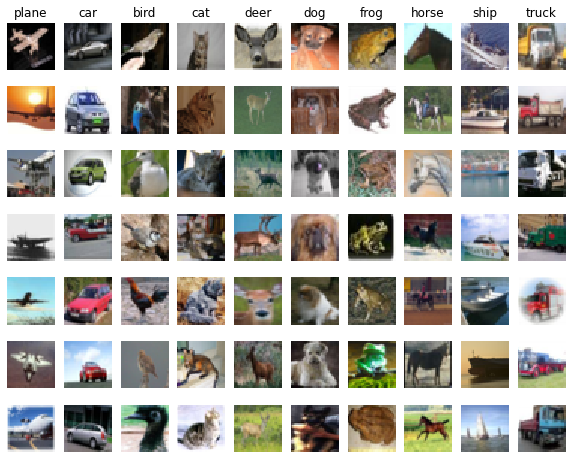

In [10]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500
# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000, 1)


In [12]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


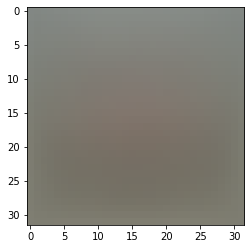

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [13]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train = X_train.astype('float32')
X_train -= mean_image
X_val = X_val.astype('float32')
X_val -= mean_image
X_test = X_test.astype('float32')
X_test -= mean_image
X_dev = X_dev.astype('float32')
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [26]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).
  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.
  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength
  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.T.shape) # initialize the gradient as zero
  s = np.dot(X,W)
  # compute the loss and the gradient
  num_classes = W.shape[1]
  N = X.shape[0]
  loss = 0.0
  svm_loss = np.zeros(s.shape[0]) 

 # Loop to compute loss and gradient
  #for i in range(0,s.shape[0]):
  for i in range(0,s.shape[0]):
    temp = 0
    multiple = 0 # to take care of the case j = y[i]
    for j in range(0,s.shape[1]):
      if j == y[i]:
        continue
      # The code piece for calculating the loss
      temp = s[i,j] - s[i,y[i]] + 1
      margin = max(0,temp)
      svm_loss[i] += margin

      # The code piece to calculate the gradient.
      if margin > 0:
        multiple += 1
        dW[j,:] += X[i] 
    dW[y[i],:] += (-1)*(multiple)*X[i] 
   
  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss = np.sum(svm_loss)
  loss /= N
  dW /= N

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)

  # Add regularization to the gradient
  dW = dW.T
  dW += 2 * reg * W
    
  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################

  return loss, dW

def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.
  Inputs and outputs are the same as svm_loss_naive.
  """

  loss = 0.0
  dW = np.zeros(W.shape)  # initialize the gradient as zero
 
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  '''
  s = np.dot(X,W)
  ones = np.ones(s.shape[0]).reshape(s.shape[0],1)
  true_class = np.take(s, y)

  margin = np.maximum(0,s - true_class + ones)
  
  margin = np.array(margin)
  y = y.reshape(1,500)
  margin[np.arange(0,margin.shape[0]),y] = 0
  
  loss = np.sum(margin)
 
  loss /= N

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  '''
 
  '''
  scores = np.dot(X, W)
  correct_class_score = np.take(scores, y).reshape(-1, 1)#Become column
  print(correct_class_score.shape)
  margin = np.maximum(0, scores - correct_class_score + 1)
  y = y.reshape(1,500)
  margin[np.arange(0,margin.shape[0]),y] = 0
  loss = np.sum(margin)/N + reg * np.sum(W*W)
  '''
  num_train = X.shape[0]
  scores = np.dot(X, W)
  #correct_class_score = scores[range(num_train), list(y)].reshape(-1, 1)#Become column
  correct_class_score = np.take(scores,y).reshape(X.shape[0],1)
  margin = np.maximum(0, scores - correct_class_score + 1)
  margin[range(num_train), list(y)] = 0
  loss = np.sum(margin)/num_train + reg * np.sum(W*W)

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  '''
  margin[margin>0]=1
  margin = np.array(margin)
  margin[np.arange(0,margin.shape[0]),y] = 0
  margin[np.arange(0,margin.shape[0]),y] = -np.sum(margin,axis=1)

  dW = np.dot(margin.T,X)
  '''
  num_class = W.shape[1]
  m = np.zeros((num_train, num_class))
  m[margin > 0] = 1
  m[range(num_train), list(y)] = 0
  m[range(num_train), list(y)] = -np.sum(m, axis=1)
  dW = np.dot(X.T, m)/num_train +2* reg * W

  '''
  dW /= N

  # Add regularization to the gradient
  dW = dW.T
  dW += 2 * reg * W
  '''
  return loss, dW
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [18]:
# Evaluate the naive implementation of the loss we provided for you:
#from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.483648


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
from random import randrange

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
  sample a few random elements and only return numerical
  in this dimensions.
  """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h  # increment by h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [ ]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
#from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -25.148489 analytic: -25.148489, relative error: 1.411211e-12
numerical: 3.665112 analytic: 3.665112, relative error: 7.586544e-12
numerical: 8.386783 analytic: 8.386783, relative error: 1.258647e-12
numerical: 13.935755 analytic: 13.935755, relative error: 4.211019e-12
numerical: -24.487080 analytic: -24.487080, relative error: 7.788175e-13
numerical: 1.714808 analytic: 1.714808, relative error: 5.670218e-12
numerical: 28.439930 analytic: 28.439930, relative error: 1.275745e-12
numerical: -11.507351 analytic: -11.507351, relative error: 2.112900e-12
numerical: 2.335808 analytic: 2.335808, relative error: 5.644730e-12
numerical: 12.432475 analytic: 12.432475, relative error: 1.293710e-12
numerical: 14.141363 analytic: 14.141363, relative error: 3.835255e-12
numerical: 9.997331 analytic: 9.997331, relative error: 4.015105e-12
numerical: 13.115796 analytic: 13.115796, relative error: 4.236113e-12
numerical: -24.144550 analytic: -24.144550, relative error: 3.838312e-12
numerica

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [19]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation.
  Inputs and outputs are the same as svm_loss_naive.
  """

  loss = 0.0
  dW = np.zeros(W.shape)  # initialize the gradient as zero
  N = X.shape[0]
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  
  # debug check the values in stages
  s = np.dot(X,W)
  print("scores",s[0,:])
  print("scores",s[1,:])
  ones = np.ones(s.shape[0]).reshape(s.shape[0],1)
  true_class = np.take(s, y)
  print("true_class",true_class[0:2,:])

  margin = np.maximum(0,s - true_class + 1)
  print("margin",margin)
  
  margin = np.array(margin)
  y = y.reshape(1,500)
  print("y",y)
  margin[np.arange(0,margin.shape[0]),y] = 0
  print("margin after updating the correct class",margin[0:4,:])

  loss = np.sum(margin)
 
  loss /= N

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)

 
  '''
  scores = np.dot(X, W)
  correct_class_score = np.take(scores, y).reshape(-1, 1)#Become column
  print(correct_class_score.shape)
  margin = np.maximum(0, scores - correct_class_score + 1)
  y = y.reshape(1,500)
  margin[np.arange(0,margin.shape[0]),y] = 0
  loss = np.sum(margin)/N + reg * np.sum(W*W)
  
  num_train = X.shape[0]
  scores = np.dot(X, W)
  #correct_class_score = scores[range(num_train), list(y)].reshape(-1, 1)#Become column
  correct_class_score = np.take(scores,y).reshape(X.shape[0],1)
  margin = np.maximum(0, scores - correct_class_score + 1)
  margin[range(num_train), list(y)] = 0
  loss = np.sum(margin)/num_train + reg * np.sum(W*W)
  '''
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  '''
  margin[margin>0]=1
  margin = np.array(margin)
  margin[np.arange(0,margin.shape[0]),y] = 0
  margin[np.arange(0,margin.shape[0]),y] = -np.sum(margin,axis=1)

  dW = np.dot(margin.T,X)

  num_class = W.shape[1]
  m = np.zeros((num_train, num_class))
  m[margin > 0] = 1
  m[range(num_train), list(y)] = 0
  m[range(num_train), list(y)] = -np.sum(m, axis=1)
  dW = np.dot(X.T, m)/num_train +2* reg * W

  
  dW /= N

  # Add regularization to the gradient
  dW = dW.T
  dW += 2 * reg * W
  '''
  return loss, dW
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


In [20]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.777859e+00 computed in 0.156119s
scores [ 0.10953635 -0.04544929 -0.0770916   0.33524447 -0.09485953  0.59517439
  0.2661763  -0.72537467 -0.0315331   0.26261317]
scores [-0.08697671  0.36080544  0.0057349   0.16714189 -0.30172315  0.3934282
 -0.20139564  0.31273607 -0.30962572 -0.59784072]
true_class [[0.2661763 ]
 [0.26261317]]
margin [[0.84336005 0.68837441 0.6567321  ... 0.00844903 0.7022906  0.99643687]
 [0.65041012 1.09819227 0.74312173 ... 1.0501229  0.42776111 0.13954611]
 [1.00829187 1.06754804 0.97978564 ... 0.81332081 1.04813127 1.6487372 ]
 ...
 [1.2503769  0.70003522 0.83883994 ... 0.71468825 1.21921373 0.76103317]
 [1.37745814 1.01118582 1.65105764 ... 0.83559241 1.41590851 1.21099869]
 [1.79665406 1.72748857 1.38133504 ... 1.72019349 1.51405334 1.45311349]]
y [[6 9 0 5 3 1 1 1 6 7 7 1 5 6 4 3 1 0 5 6 8 3 1 6 8 6 1 5 8 7 4 1 1 2 0 3
  3 2 2 5 3 4 5 8 3 3 4 2 1 0 2 2 2 6 9 6 6 3 9 1 2 9 8 0 4 5 3 2 8 8 3 9
  3 6 0 3 8 7 3 0 9 4 0 4 9 9 0 7 0 0 2 9 7 8 5 0 3 9

In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.139795s
Vectorized loss and gradient: computed in 0.022050s
difference: 3494.018415


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [56]:
import numpy as np
#from cs231n.classifiers.linear_svm import *
#from cs231n.classifiers.softmax import *

class LinearClassifier(object):

  def __init__(self):
    self.W = None

  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
    if self.W is None:
      # lazily initialize W
      self.W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      
      mask = np.random.choice(num_train,batch_size)
    
      X_batch = X[mask]
      y_batch = y[mask]
        
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
      loss, grad = self.loss(X_batch, y_batch, reg)
      loss_history.append(loss)

      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      
      self.W -= learning_rate * grad  
        
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.
    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.
    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    
    scores = np.dot(X,self.W)
    y_pred = np.argmax(scores,axis=1)
    
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.
    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.
    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, X_batch, y_batch, reg):
    #return svm_loss_vectorized(self.W, X_batch, y_batch, reg)
    return svm_loss_naive(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [57]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
#from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 786.088425
iteration 100 / 1500: loss 286.554119
iteration 200 / 1500: loss 107.212556
iteration 300 / 1500: loss 41.927053
iteration 400 / 1500: loss 19.005132
iteration 500 / 1500: loss 9.681269
iteration 600 / 1500: loss 7.163416
iteration 700 / 1500: loss 5.482742
iteration 800 / 1500: loss 4.673124
iteration 900 / 1500: loss 6.034195
iteration 1000 / 1500: loss 5.498686
iteration 1100 / 1500: loss 5.465226
iteration 1200 / 1500: loss 5.216195
iteration 1300 / 1500: loss 5.060048
iteration 1400 / 1500: loss 5.086001
That took 62.763201s


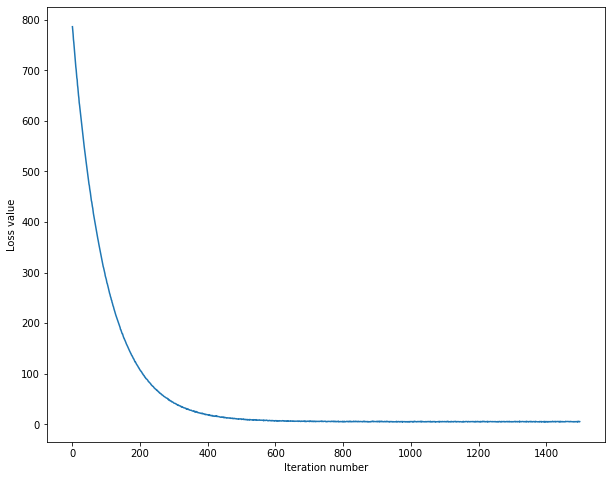

In [58]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [59]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.099987
validation accuracy: 0.101904


In [69]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
#learning_rates = [1e-7, 5e-5]
#regularization_strengths = [2.5e4, 5e4]
#learning_rates = [1e-7,1e-8,1e-6]
learning_rates = [1e-5,1e-6,1e-7]
#5e3,2.5e4
regularization_strengths = [100,250,5e2,1000,2500]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass
# combination of the learning rates and regularization strength.
# Total of 4 combinations 
# results dictionary to store values of train and validation accuracy for each combination of hyperparameters

# while doing our first run a learning rate of 5e-5 gives extreme values. 
results = {}

for lr in learning_rates:
  for reg in regularization_strengths:

    print(lr)
    print(reg)
    svm = LinearSVM()
    loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,num_iters=2000, verbose=True)
    # prediction and accuracy
    y_train_pred = svm.predict(X_train)
    train_acc = np.mean(y_train == y_train_pred)
    print("train_accuracy",train_acc)
    y_val_pred = svm.predict(X_val)
    val_acc = np.mean(y_val == y_val_pred)
    print("Validation accuracy",val_acc)
    results[(lr,reg)] = (train_acc, val_acc)

    if val_acc > best_val:
      best_val = val_acc
      best_svm = svm


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-05
100
iteration 0 / 2000: loss 24.704153
iteration 100 / 2000: loss 22.849044
iteration 200 / 2000: loss 21.958037
iteration 300 / 2000: loss 35.504316
iteration 400 / 2000: loss 27.488373
iteration 500 / 2000: loss 14.280070
iteration 600 / 2000: loss 16.765469
iteration 700 / 2000: loss 25.443968
iteration 800 / 2000: loss 23.352923
iteration 900 / 2000: loss 24.709343
iteration 1000 / 2000: loss 21.382760
iteration 1100 / 2000: loss 24.586885
iteration 1200 / 2000: loss 36.462284
iteration 1300 / 2000: loss 28.106607
iteration 1400 / 2000: loss 19.625626
iteration 1500 / 2000: loss 14.288369
iteration 1600 / 2000: loss 17.932083
iteration 1700 / 2000: loss 22.394924
iteration 1800 / 2000: loss 15.988256
iteration 1900 / 2000: loss 16.113094
train_accuracy 0.10000967138692211
Validation accuracy 0.100139
1e-05
250
iteration 0 / 2000: loss 29.529383
iteration 100 / 2000: loss 24.479156
iteration 200 / 2000: loss 19.197039
iteration 300 / 2000: loss 28.954682
iteration 400 / 2000: 

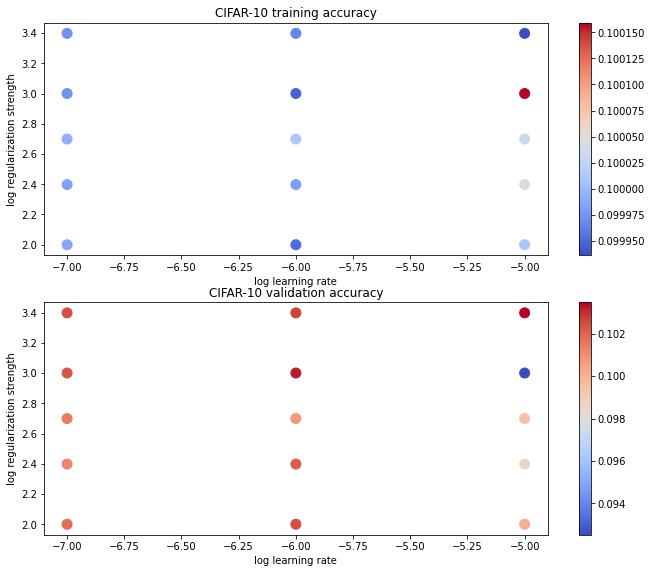

In [70]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [71]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.098337


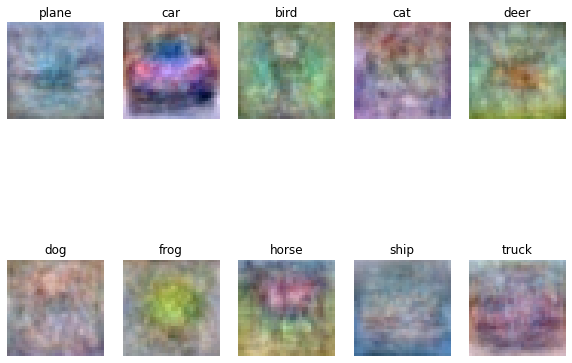

In [72]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  


# Rough Work

In [ ]:
X_dev_test = X_dev[0:20,:]
print(X_dev_test.shape)
print(W.shape)
print(X_dev_test[0].shape)

X_dev_test = X_dev_test[:,np.newaxis]
print(X_dev_test.shape)
print(X_dev_test[0].shape)
W = np.random.randn(3073, 10) * 0.0001
W = W.T
print(W[:,0].shape)
W = W[np.newaxis,:]
print(W.shape)
print(W[:,0].shape)

W[:,0]+=X_dev_test[0]

(20, 3073)
(3073, 10)
(3073,)
(20, 1, 3073)
(1, 3073)
(10,)
(1, 10, 3073)
(1, 3073)
